In [ ]:
!conda install mkl-service -y

In [28]:
import os

import numpy as np
import pandas as pd
import pymc3 as pm
from IPython.core.debugger import set_trace

In [29]:
COUNTY_LEVEL_URL = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

df = pd.read_csv(COUNTY_LEVEL_URL)
df.head()

date     county       state     fips  cases  deaths
0  2020-01-21  Snohomish  Washington  53061.0      1       0
1  2020-01-22  Snohomish  Washington  53061.0      1       0
2  2020-01-23  Snohomish  Washington  53061.0      1       0
3  2020-01-24       Cook    Illinois  17031.0      1       0
4  2020-01-24  Snohomish  Washington  53061.0      1       0

In [30]:
michigan_df = df.iloc[(df['state']=='Michigan').values]
michigan_df.tail()

date     county     state     fips  cases  deaths
22760  2020-03-31    Unknown  Michigan      NaN     93       0
22761  2020-03-31  Van Buren  Michigan  26159.0      7       0
22762  2020-03-31  Washtenaw  Michigan  26161.0    311       7
22763  2020-03-31      Wayne  Michigan  26163.0   3735     120
22764  2020-03-31    Wexford  Michigan  26165.0      2       0

In [33]:
statewide = michigan_df.groupby(['date'])['cases', 'deaths'].sum().reset_index()
#new_data = pd.DataFrame.from_dict([{'date': '2020-04-01', 'cases': 9334, 'deaths': 337}])
#statewide = pd.concat([statewide, new_data], ignore_index=True)
statewide['daily_cases'] = statewide['cases'].diff().apply(lambda x: statewide['cases'][0] if np.isnan(x) else x)
statewide

/home/ryan/python/notebooks/covid19_exponential_model/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


date  cases  deaths  daily_cases
0   2020-03-10      2       0          2.0
1   2020-03-11      2       0          0.0
2   2020-03-12     12       0         10.0
3   2020-03-13     25       0         13.0
4   2020-03-14     33       0          8.0
5   2020-03-15     53       0         20.0
6   2020-03-16     54       0          1.0
7   2020-03-17     65       0         11.0
8   2020-03-18     80       1         15.0
9   2020-03-19    334       3        254.0
10  2020-03-20    548       4        214.0
11  2020-03-21    787       6        239.0
12  2020-03-22   1033       9        246.0
13  2020-03-23   1324      16        291.0
14  2020-03-24   1783      24        459.0
15  2020-03-25   2286      43        503.0
16  2020-03-26   2878      63        592.0
17  2020-03-27   3652      93        774.0
18  2020-03-28   4637     112        985.0
19  2020-03-29   5473     132        836.0
20  2020-03-30   6509     197       1036.0
21  2020-03-31   7630     264       1121.0
22  2020-04-01   9334     337       1704.0

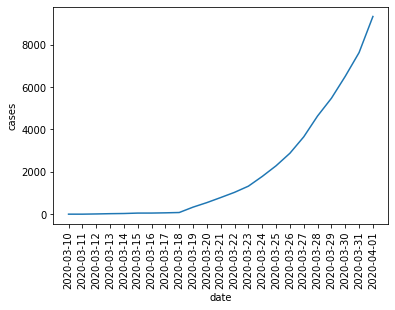

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(statewide['date'],statewide['cases'])
xticks = plt.xticks(statewide['date'], rotation='vertical')

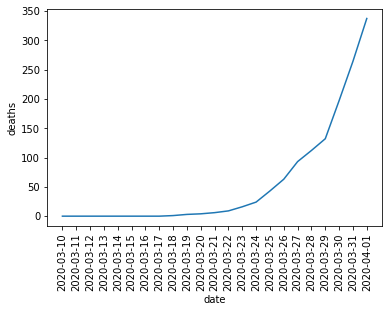

In [35]:
sns.lineplot(statewide['date'],statewide['deaths'])
xticks = plt.xticks(statewide['date'], rotation='vertical')

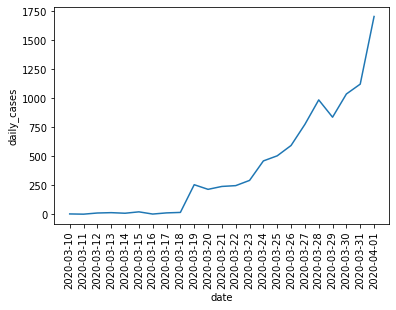

In [36]:
sns.lineplot(statewide['date'],statewide['daily_cases'])
xticks = plt.xticks(statewide['date'], rotation='vertical')

In [37]:
statewide['has_cases'] = statewide['cases'].apply(lambda x: 1 if x>=0 else 0)
statewide['days_since'] = statewide['has_cases'].cumsum()-1

filtered_statewide = statewide.iloc[(statewide['cases']>1000).values]
filtered_statewide

date  cases  deaths  daily_cases  has_cases  days_since
12  2020-03-22   1033       9        246.0          1          12
13  2020-03-23   1324      16        291.0          1          13
14  2020-03-24   1783      24        459.0          1          14
15  2020-03-25   2286      43        503.0          1          15
16  2020-03-26   2878      63        592.0          1          16
17  2020-03-27   3652      93        774.0          1          17
18  2020-03-28   4637     112        985.0          1          18
19  2020-03-29   5473     132        836.0          1          19
20  2020-03-30   6509     197       1036.0          1          20
21  2020-03-31   7630     264       1121.0          1          21
22  2020-04-01   9334     337       1704.0          1          22

In [38]:
with pm.Model() as model:
    a = pm.Lognormal('a', 1)
    gamma = pm.Normal('g', 1, 10)
    lam = pm.HalfNormal('lam', 5.)
    rho = pm.Lognormal('r', 1, 10)
    sigma = pm.HalfNormal('sigma', 5.)
    x = pm.Data('x_data', filtered_statewide['days_since'])
    b = pm.Deterministic('b',gamma*pm.math.exp(-1*rho*x))
    c = pm.Deterministic('c', pm.math.exp(-1*lam*x))
    y = pm.Data('y_data', filtered_statewide['daily_cases'])
    pm.NegativeBinomial('output', a*c+b**x,sigma,  observed=y)

In [39]:
with model:
    trace = pm.sample(tune=5000, chains=2, cores=4, target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, r, lam, g, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [02:02<00:00, 89.53draws/s] 


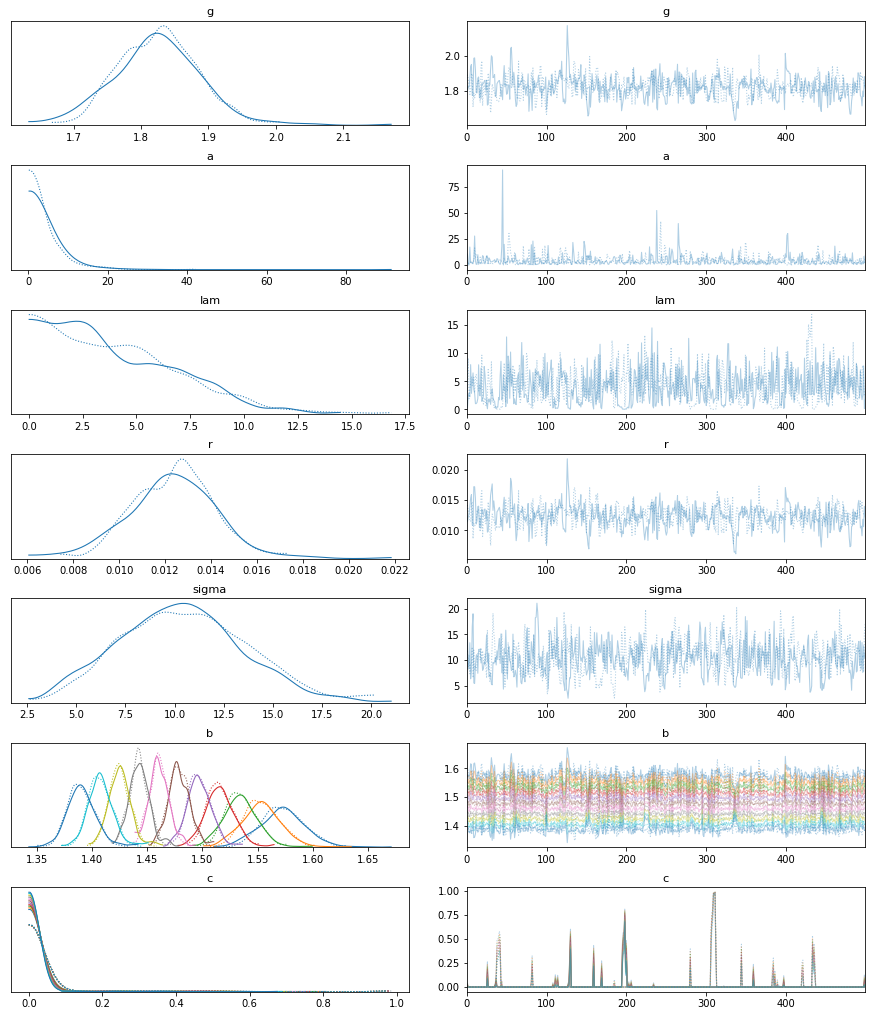

In [40]:
tp = pm.traceplot(trace)

In [41]:
with model:
    x_data = np.arange(0,45)
    y_data = np.array([np.nan]*len(x_data))
    pm.set_data({'x_data':x_data, 'y_data':y_data})
    post_pred = pm.sample_posterior_predictive(trace, samples=5000)

100%|██████████| 5000/5000 [00:44<00:00, 111.81it/s]


In [42]:
from datetime import datetime

time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
path = f'./Traces/daily_model_{time}.trace'
pm.save_trace(trace, directory=path)

'./Traces/daily_model_2020-04-01-17-08-24.trace'

In [43]:
arr = post_pred['output']
preds = arr.flatten().tolist() 
idx = (np.indices(arr.shape)[1].flatten()).tolist()
pred_df = pd.DataFrame()
pred_df['days_since'] = idx
pred_df['prediction'] = preds
pred_df.head()

days_since  prediction
0           0          11
1           1           2
2           2           7
3           3           8
4           4          11

In [44]:
test = pred_df.groupby(['days_since'])['prediction'].apply(lambda x: np.array(x)).reset_index()
test.columns = ['days_since', 'array']
test['array'][44]

array([16, 43, 27, ..., 11, 14,  8])

In [45]:
pred_grouped = pred_df.groupby(['days_since']).agg({
    'prediction': ['mean', lambda x: np.percentile(x,50), lambda x: np.percentile(x,5), lambda x: np.percentile(x,95)]
}).reset_index()
pred_grouped.columns = ['days_since', 'mean', 'median', 'percentile_5', 'percentile_95']
pred_grouped.tail()

days_since      mean  median  percentile_5  percentile_95
40          40  342.4082    66.0           5.0        1094.15
41          41  271.8768    45.0           3.0         844.00
42          42  241.3862    29.0           1.0         708.05
43          43  195.0696    19.0           0.0         536.00
44          44  179.2004    11.0           0.0         413.05

Text(0.5, 1.0, 'COVID Exponential Prediction (Daily Cases)')

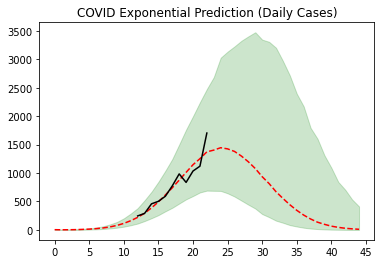

In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()
ax.plot(pred_grouped['days_since'], pred_grouped['median'], color='red', linestyle='dashed')
ax.plot(filtered_statewide['days_since'], filtered_statewide['daily_cases'], color='black')

ax.fill_between(pred_grouped['days_since'], pred_grouped['percentile_5'], pred_grouped['percentile_95'], alpha=0.2, color='green')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('COVID Exponential Prediction (Daily Cases)')

In [47]:
from datetime import datetime

time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
path = f'./Figures/daily_{time}.png'
fig.savefig(path)

In [48]:
total_arr = post_pred['output'].cumsum(axis=1)
total_preds = total_arr.flatten().tolist() 
total_idx = (np.indices(total_arr.shape)[1].flatten()).tolist()
total_pred_df = pd.DataFrame()
total_pred_df['days_since'] = total_idx
total_pred_df['prediction'] = total_preds
total_pred_df.head()

days_since  prediction
0           0          11
1           1          13
2           2          20
3           3          28
4           4          39

In [49]:
total_preds_df = total_pred_df.groupby(['days_since'])['prediction'].apply(lambda x: np.array(x)).reset_index()
total_preds_df['mean'] = total_preds_df['prediction'].apply(lambda x: np.mean(x))
total_preds_df['median'] = total_preds_df['prediction'].apply(lambda x: np.percentile(x, 50))
total_preds_df['percentile_5'] = total_preds_df['prediction'].apply(lambda x: np.percentile(x, 5))
total_preds_df['percentile_95'] = total_preds_df['prediction'].apply(lambda x: np.percentile(x, 95))
total_preds_df.tail()

days_since                                         prediction        mean  \
40          40  [26031, 29793, 26500, 18780, 15516, 17029, 142...  28701.1576   
41          41  [26090, 29961, 26646, 18796, 15522, 17035, 142...  28973.0344   
42          42  [26140, 30053, 26693, 18815, 15530, 17037, 142...  29214.4206   
43          43  [26155, 30113, 26747, 18827, 15535, 17039, 142...  29409.4902   
44          44  [26171, 30156, 26774, 18834, 15538, 17039, 142...  29588.6906   

     median  percentile_5  percentile_95  
40  23637.5      14971.00        55352.4  
41  23680.5      14979.80        56378.3  
42  23712.5      14981.85        57044.0  
43  23725.5      14982.95        57453.6  
44  23738.0      14983.95        57883.8

Text(0.5, 1.0, 'COVID Exponential Prediction (Total Cases)')

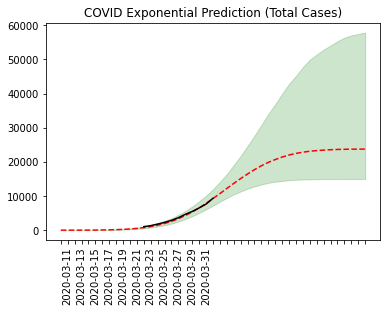

In [50]:
fig, ax = plt.subplots()
ax.plot(total_preds_df['days_since'], total_preds_df['median'], color='red', linestyle='dashed')
ax.plot(filtered_statewide['days_since'], filtered_statewide['cases'], color='black')

ax.fill_between(total_preds_df['days_since'], total_preds_df['percentile_5'], total_preds_df['percentile_95'], alpha=0.2, color='green')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

xticks = plt.xticks(total_preds_df['days_since'], rotation='vertical')
xticklabels = ax.set_xticklabels(statewide['date'])
for label in xticklabels[::2]:
    label.set_visible(False)
plt.title('COVID Exponential Prediction (Total Cases)')

In [51]:
time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
path = f'./Figures/daily_{time}.png'
fig.savefig(path)